In [2]:
import pandas as pd
import numpy as np
import collections
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os
import json
import seaborn as sns



### Read in the replier only graph and convert to data frame

In [3]:
only_replier = nx.read_gpickle("./repliers_only_graph.pickle")
E= nx.Graph(only_replier)

(nx.number_of_nodes(E),nx.number_of_edges(E))#(902, 5287)



(902, 5287)

#### 1. find the largest component

c:\users\tracy.shen\appdata\local\programs\python\python36\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


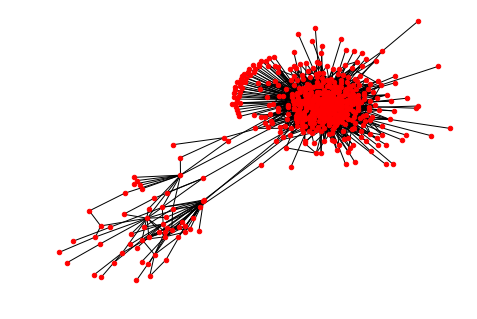

In [4]:

largest=max(nx.connected_component_subgraphs(E),key=len)
# largest_n=nx.convert_node_labels_to_integers(largest,first_label=1)
nx.draw(largest,node_size=20)

#### 2. find the largest connected component radius, diameter, centroids, periphery

In [ ]:
nx.center(largest)#['freedom_girlbot']

# largest.nodes(data=True)

nx.periphery(largest)#['TLYNNB7', 'MyKidsHavePaws', 'NRABoycott']

nx.radius(largest)#4, the smallest eccentricity among all the nodes, eccentricity is the largest distance between this node to other nodes

nx.diameter(largest)#8, the maximum eccentricity among all the nodes

(nx.number_of_nodes(largest),nx.number_of_edges(largest))#(565, 5281)

#### 3. Match the label for the nodes in the largest component

In [5]:
nodes=pd.Series(largest.nodes())
node_df=pd.Series.to_frame(nodes,name='node')

labels=pd.read_csv('replier_majority_labled.csv',encoding='utf-8')
largest_label=pd.merge(node_df,labels,how='inner', left_on='node',right_on='screen_name')
largest_label.shape#(472, 28)
largest_label.columns
largest_label0=largest_label[['node','stance']]
largest_label0.head()
len(largest_label0['node'].unique())#457, 15 duplicated cases
largest_label.to_csv('largest_nw_label.csv',index=False)

largest_label0.to_csv('largest_nw_label_narrow.csv',index=False)

* initial converting with only node and stance columns

In [21]:
largest_label0=pd.read_csv('largest_nw_label_narrow.csv')
largest_label0.head()
pd.crosstab(index=largest_label0['stance'],columns='percentage').apply(lambda r: round(r/len(largest_label0),2)*100,axis=1).reset_index()

col_0,stance,percentage
0,Neutral,30.0
1,Strong Agreement,46.0
2,Strong Disagreement,7.0
3,Weak Agreement,13.0
4,Weak Disagreement,5.0


* Find there are 15 nodes that have duplicated stances

In [ ]:
largest_label.shape
len(node_df['node'].unique())
largest_label.head()
largest_label0[largest_label0.duplicated('node')]

#### 4. Convert network to pandas data frame and find the relationship

In [7]:
# deg=largest.degree()
# edge=nx.to_pandas_dataframe(largest)
largest_df=nx.to_pandas_edgelist(largest)
# largest_df.to_csv('largest_nw_df.csv',index=False)
largest_df.shape#(5281, 3)
largest_df.head()

,source,target,direction
0,Sunshin68748888,MarkDice,followed by
1,MarkDice,rockinrobyn59,followed by
2,MarkDice,america_trust,followed by
3,MarkDice,JerilynneGraue,followed by
4,MarkDice,talkingdeer,followed by


#### 5. Merge the edge list with the labels: obtain both source and target node stance

In [ ]:
largest_label0.head()
largest_labeled=pd.merge(largest_df,largest_label0,how='inner',left_on='source',right_on='node')
largest_labeled.head()
largest_labeled.shape#(4361, 5)
largest_labeled_both=pd.merge(largest_labeled,largest_label0,how='inner',left_on='target',right_on='node')
largest_labeled_both.shape#outer: (4448, 7), inner:(3675, 7)
len(largest_labeled_both['target'].unique())#414

len(largest_labeled['target'].unique())#511
len(largest_labeled['source'].unique())#273
largest_labeled_both.head()
largest_labeled_both0=largest_labeled_both.drop(['node_x','node_y'],axis=1)

largest_labeled_both0.rename(columns={'stance_x':'source_stance','stance_y':'target_stance'},inplace=True)
largest_labeled_both0.head()
largest_labeled_both0.to_csv('largest_labeled_both.csv',index=False)

+ **read in the data frame with source, target, direction and source_stance, target_stance**

In [50]:
largest_labeled_both0=pd.read_csv('largest_labeled_both.csv')
largest_labeled_both0.shape#(3675, 5)
largest_labeled_both0['source_stance']=largest_labeled_both0['source_stance'].str.split(" ",expand=True)

largest_labeled_both0['source_target_stance']=largest_labeled_both0['source']+'-'+largest_labeled_both0['source_stance']+"-"+largest_labeled_both0['target_stance']
largest_labeled_both0.head()

,source,target,direction,source_stance,target_stance,source_target_stance
0,rockinrobyn59,LoriinUtah,followed by,Weak Agreement,Weak Agreement,rockinrobyn59-Weak Agreement-Weak Agreement
1,rockinrobyn59,LoriinUtah,followed by,Strong Agreement,Weak Agreement,rockinrobyn59-Strong Agreement-Weak Agreement
2,tasteofaz,LoriinUtah,followed by,Strong Agreement,Weak Agreement,tasteofaz-Strong Agreement-Weak Agreement
3,briantopping66,LoriinUtah,followed by,Strong Agreement,Weak Agreement,briantopping66-Strong Agreement-Weak Agreement
4,PaulHook_em,LoriinUtah,followed by,Neutral,Weak Agreement,PaulHook_em-Neutral-Weak Agreement


In [51]:
largest_labeled_both0.to_csv('largest_labeled_stance_direction.csv',index=False)

### Network EDA

#### 1. find the highest degree nodes

In [12]:
degree=dict(largest.degree())
deg_df=pd.DataFrame(dict(DEGREE=degree)).reset_index()
# deg_df.head()

deg_df.sort_values('DEGREE',ascending=False).head(11)

deg_df.to_csv('degree-df.csv',index=False)

,index,DEGREE
199,MarkDice,296
336,adjunctprofessr,196
224,PaulHook_em,168
172,Just_a_Texan,163
500,poconomtn,154
497,petefrt,151
200,MarshaPeters919,135
49,CHearSpeakNEvil,116
187,LoriMillerTX1,114
225,PennyHicks13,113


#### 2 Get all the nodes labeled and find the disagreement users subset

In [99]:
deg_df=pd.read_csv('degree-df.csv')
largest_labeled_both0=pd.read_csv('largest_labeled_both.csv')
node_labeled=pd.merge(deg_df,largest_labeled_both0,how='left',left_on='index',right_on='source')
node_labeled.head()

node_labeled.shape#(3979, 7)
node_labeled.to_csv('node_labeled.csv',index=False)

node_labeled=pd.merge(deg_df,largest_labeled_both0,how='left',left_on='index',right_on='source')
node_labeled.head()
DA=node_labeled[node_labeled['source_stance']=='Strong Disagreement']
DA.shape#(97, 8)
# DA.sort_values('DEGREE',ascending=False)


DA_deg=deg_df[deg_df['index'].isin(DA['index'].unique())]#(97, 8)
DA_deg #unique disagreer degrees

node_labeled.shape#(3979, 7)
node_labeled.head()
DA.to_csv('disagreement_degrees.csv',index=False)
DA_deg.sort_values('DEGREE',ascending=False)

DA_deg_label=pd.merge(DA_deg,largest_label0,how='inner', left_on='index',right_on='node')
da_sorted=DA_deg_label.sort_values('DEGREE',ascending=False)
da_sorted

,index,DEGREE,node,stance
11,TrumpsWirl,53,TrumpsWirl,Strong Disagreement
4,DiCam3667Trump,34,DiCam3667Trump,Strong Disagreement
13,__SERIOUSLY___,25,__SERIOUSLY___,Strong Disagreement
7,NolesSC,23,NolesSC,Strong Disagreement
3,Deplorable_JJ,21,Deplorable_JJ,Strong Disagreement
5,DrQuesol,18,DrQuesol,Strong Disagreement
8,RKJ65,13,RKJ65,Strong Disagreement
12,ZemanLynnZ,10,ZemanLynnZ,Strong Disagreement
2,Billy_Barrell,9,Billy_Barrell,Strong Disagreement
18,picassobox,9,picassobox,Strong Disagreement


#### 3. For strong agreers such as adj_prof, CHearSpeakNEvil, Just_a_Texan, what are the follower stance

In [58]:
pd.crosstab(index=adj_prof['target_stance'],columns='percentage').apply(lambda r:round(r/len(adj_prof['target_stance'])*100,2),axis=1).reset_index()

col_0,target_stance,percentage
0,Neutral,27.33
1,Strong Agreement,48.00
2,Strong Disagreement,4.00
3,Weak Agreement,19.33
4,Weak Disagreement,1.33


In [60]:
chear=top11_labeled_both[top11_labeled_both['source']=='CHearSpeakNEvil']
pd.crosstab(index=chear['target_stance'],columns='percentage').apply(lambda r:round(r/len(chear['target_stance'])*100,2),axis=1).reset_index()


col_0,target_stance,percentage
0,Neutral,28.95
1,Strong Agreement,50.00
2,Strong Disagreement,3.95
3,Weak Agreement,15.79
4,Weak Disagreement,1.32


In [62]:
just=top11_labeled_both[top11_labeled_both['source']=='Just_a_Texan']
pd.crosstab(index=just['target_stance'],columns='percentage').apply(lambda r:round(r/len(just['target_stance'])*100,2),axis=1).reset_index()


col_0,target_stance,percentage
0,Neutral,27.82
1,Strong Agreement,45.86
2,Strong Disagreement,5.26
3,Weak Agreement,16.54
4,Weak Disagreement,4.51


In [ ]:
adj_prof_graph=nx.from_pandas_edgelist(adj_prof,source='index',target='target',edge_attr='source_target_stance',create_using=nx.Graph)
nx.draw(adj_prof_graph,node_color='g',node_size=20)

#### 4.For strong disagreers such as "TrumpsWirl,DiCam3667Trump,__SERIOUSLY___' , their followers are mostly strong agreers 


In [100]:
da_sorted

,index,DEGREE,node,stance
11,TrumpsWirl,53,TrumpsWirl,Strong Disagreement
4,DiCam3667Trump,34,DiCam3667Trump,Strong Disagreement
13,__SERIOUSLY___,25,__SERIOUSLY___,Strong Disagreement
7,NolesSC,23,NolesSC,Strong Disagreement
3,Deplorable_JJ,21,Deplorable_JJ,Strong Disagreement
5,DrQuesol,18,DrQuesol,Strong Disagreement
8,RKJ65,13,RKJ65,Strong Disagreement
12,ZemanLynnZ,10,ZemanLynnZ,Strong Disagreement
2,Billy_Barrell,9,Billy_Barrell,Strong Disagreement
18,picassobox,9,picassobox,Strong Disagreement


In [130]:
twirl=node_labeled[node_labeled['source']=='TrumpsWirl']
pd.crosstab(index=twirl['target_stance'],columns='target%').apply(lambda r:round(r/len(twirl['target_stance'])*100,2),axis=1).reset_index()


col_0,target_stance,target%
0,Neutral,25.0
1,Strong Agreement,50.0
2,Weak Agreement,25.0


In [129]:
twirl=DA_T[DA_T['target']=='TrumpsWirl']
pd.crosstab(index=twirl['source_stance'],columns='source_stance%').apply(lambda r:round(r/len(twirl['target_stance'])*100,2),axis=1).reset_index()


col_0,source_stance,source_stance%
0,Neutral,22.22
1,Strong Agreement,40.74
2,Strong Disagreement,3.70
3,Weak Agreement,25.93
4,Weak Disagreement,7.41


In [96]:
dicam=node_labeled[node_labeled['source']=='DiCam3667Trump']
pd.crosstab(index=dicam['target_stance'],columns='percentage').apply(lambda r:round(r/len(dicam['target_stance'])*100,2),axis=1).reset_index()


col_0,target_stance,percentage
0,Neutral,29.41
1,Strong Agreement,41.18
2,Strong Disagreement,11.76
3,Weak Agreement,17.65


In [131]:
dicam=DA_T[DA_T['target']=='DiCam3667Trump']
pd.crosstab(index=dicam['source_stance'],columns='source_stance%').apply(lambda r:round(r/len(dicam['target_stance'])*100,2),axis=1).reset_index()


col_0,source_stance,source_stance%
0,Neutral,22.22
1,Strong Agreement,77.78


In [97]:
serious=node_labeled[node_labeled['source']=='__SERIOUSLY___']
pd.crosstab(index=serious['target_stance'],columns='percentage').apply(lambda r:round(r/len(serious['target_stance'])*100,2),axis=1).reset_index()


col_0,target_stance,percentage
0,Neutral,11.11
1,Strong Agreement,77.78
2,Strong Disagreement,11.11


In [132]:
serious=DA_T[DA_T['target']=='__SERIOUSLY___']
pd.crosstab(index=serious['source_stance'],columns='source_stance%').apply(lambda r:round(r/len(serious['target_stance'])*100,2),axis=1).reset_index()


col_0,source_stance,source_stance%
0,Neutral,35.71
1,Strong Agreement,50.00
2,Weak Agreement,14.29


In [101]:

nole=node_labeled[node_labeled['source']=='NolesSC']
pd.crosstab(index=nole['target_stance'],columns='percentage').apply(lambda r:round(r/len(nole['target_stance'])*100,2),axis=1).reset_index()
# same for Deplorable_JJ

col_0,target_stance,percentage
0,Neutral,50.00
1,Strong Agreement,33.33
2,Weak Agreement,8.33
3,Weak Disagreement,8.33


In [135]:
nole=DA_T[DA_T['target']=='NolesSC']
pd.crosstab(index=nole['source_stance'],columns='source_stance%').apply(lambda r:round(r/len(nole['target_stance'])*100,2),axis=1).reset_index()


col_0,source_stance,source_stance%
0,Strong Agreement,80.0
1,Weak Agreement,20.0


In [106]:


rkj=node_labeled[node_labeled['source']=='RKJ65']
pd.crosstab(index=rkj['target_stance'],columns='percentage').apply(lambda r:round(r/len(rkj['target_stance'])*100,2),axis=1).reset_index()


col_0,target_stance,percentage
0,Neutral,36.36
1,Strong Agreement,9.09
2,Strong Disagreement,27.27
3,Weak Agreement,18.18
4,Weak Disagreement,9.09


In [133]:
rkj=DA_T[DA_T['target']=='RKJ65']
pd.crosstab(index=rkj['source_stance'],columns='source_stance%').apply(lambda r:round(r/len(rkj['target_stance'])*100,2),axis=1).reset_index()


col_0,source_stance,source_stance%
0,Strong Agreement,100.0


In [107]:

dr=node_labeled[node_labeled['source']=='DrQuesol']
pd.crosstab(index=dr['target_stance'],columns='percentage').apply(lambda r:round(r/len(dr['target_stance'])*100,2),axis=1).reset_index()


col_0,target_stance,percentage
0,Neutral,100.0


In [134]:
dr=DA_T[DA_T['target']=='DrQuesol']
pd.crosstab(index=dr['source_stance'],columns='source_stance%').apply(lambda r:round(r/len(dr['target_stance'])*100,2),axis=1).reset_index()


col_0,source_stance,source_stance%
0,Neutral,23.08
1,Strong Agreement,46.15
2,Strong Disagreement,7.69
3,Weak Agreement,15.38
4,Weak Disagreement,7.69


#### 5. Why this happens

In [108]:
node_labeled.head()

,index,DEGREE,source,target,direction,source_stance,target_stance,source_target_stance
0,0SweetSolace0,4,NaN,NaN,NaN,NaN,NaN,NaN
1,100011crusader,11,NaN,NaN,NaN,NaN,NaN,NaN
2,1206geauxtigers,5,1206geauxtigers,Amusedandhappy,followed by,Strong Disagreement,Strong Agreement,1206geauxtigers-Strong Disagreement-Strong Agr...
3,1206geauxtigers,5,1206geauxtigers,Amusedandhappy,followed by,Neutral,Strong Agreement,1206geauxtigers-Neutral-Strong Agreement
4,17erudolph,1,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
pd.crosstab(index=node_labeled['source_stance'],columns='percentage').apply(lambda r:round(r/len(node_labeled),2)*100,axis=1).reset_index()

col_0,source_stance,percentage
0,Neutral,24.0
1,Strong Agreement,49.0
2,Strong Disagreement,2.0
3,Weak Agreement,14.0
4,Weak Disagreement,4.0


In [110]:
pd.crosstab(index=node_labeled['target_stance'],columns='percentage').apply(lambda r:round(r/len(node_labeled),2)*100,axis=1).reset_index()

col_0,target_stance,percentage
0,Neutral,26.0
1,Strong Agreement,45.0
2,Strong Disagreement,4.0
3,Weak Agreement,15.0
4,Weak Disagreement,3.0


#### 6. analyze on the center/periphery nodes

In [22]:
center_label=deg_df[deg_df['index'].isin(nx.center(sub_largest))]
center_label.shape#(8, 2)

(8, 2)

#### 6.1 find the label for all the center nodes

In [23]:
center_deg_label=pd.merge(center_label,largest_label0,how='inner', left_on='index',right_on='node')
center_deg_label

,index,DEGREE,node,stance
0,G_Pond47,71,G_Pond47,Strong Agreement
1,MarshaPeters919,135,MarshaPeters919,Neutral
2,PaulHook_em,168,PaulHook_em,Neutral
3,PennyHicks13,113,PennyHicks13,Weak Agreement
4,TrumpWillWinnn,69,TrumpWillWinnn,Strong Agreement
5,adjunctprofessr,196,adjunctprofessr,Strong Agreement
6,jthunda65,89,jthunda65,Weak Agreement
7,petefrt,151,petefrt,Strong Agreement


In [24]:
pd.crosstab(index=center_deg_label['stance'],columns='percentage').apply(lambda r:round(r/len(center_deg_label),2)*100,axis=1).reset_index()

col_0,stance,percentage
0,Neutral,25.0
1,Strong Agreement,50.0
2,Weak Agreement,25.0


#### 6.2 Check how many nodes that connected with the center nodes are strong agreement

In [29]:
adjunc=node_labeled[node_labeled['source']=='adjunctprofessr']
pd.crosstab(index=adjunc['target_stance'],columns='target%').apply(lambda r:round(r/len(adjunc['target_stance'])*100,2),axis=1).reset_index()


col_0,target_stance,target%
0,Neutral,27.33
1,Strong Agreement,48.00
2,Strong Disagreement,4.00
3,Weak Agreement,19.33
4,Weak Disagreement,1.33


+ check the followers' stance of the center nodes

In [30]:
paulh=node_labeled[node_labeled['source']=='PaulHook_em']
pd.crosstab(index=paulh['target_stance'],columns='target%').apply(lambda r:round(r/len(paulh['target_stance'])*100,2),axis=1).reset_index()


col_0,target_stance,target%
0,Neutral,25.90
1,Strong Agreement,56.12
2,Strong Disagreement,1.44
3,Weak Agreement,14.39
4,Weak Disagreement,2.16


In [31]:
penny=node_labeled[node_labeled['source']=='PennyHicks13']
pd.crosstab(index=penny['target_stance'],columns='target%').apply(lambda r:round(r/len(penny['target_stance'])*100,2),axis=1).reset_index()


col_0,target_stance,target%
0,Neutral,26.14
1,Strong Agreement,54.55
2,Strong Disagreement,4.55
3,Weak Agreement,10.23
4,Weak Disagreement,4.55


In [32]:
pete=node_labeled[node_labeled['source']=='petefrt']
pd.crosstab(index=pete['target_stance'],columns='target%').apply(lambda r:round(r/len(pete['target_stance'])*100,2),axis=1).reset_index()


col_0,target_stance,target%
0,Neutral,30.63
1,Strong Agreement,45.95
2,Strong Disagreement,2.70
3,Weak Agreement,17.12
4,Weak Disagreement,3.60


In [33]:
trump=node_labeled[node_labeled['source']=='TrumpWillWinnn']
pd.crosstab(index=trump['target_stance'],columns='target%').apply(lambda r:round(r/len(trump['target_stance'])*100,2),axis=1).reset_index()


col_0,target_stance,target%
0,Neutral,22.86
1,Strong Agreement,54.29
2,Strong Disagreement,5.71
3,Weak Agreement,14.29
4,Weak Disagreement,2.86


In [34]:
jthund=node_labeled[node_labeled['source']=='jthunda65']
pd.crosstab(index=jthund['target_stance'],columns='target%').apply(lambda r:round(r/len(jthund['target_stance'])*100,2),axis=1).reset_index()


col_0,target_stance,target%
0,Neutral,43.24
1,Strong Agreement,29.73
2,Weak Agreement,27.03


In [36]:
pond=node_labeled[node_labeled['source']=='G_Pond47']
pd.crosstab(index=pond['target_stance'],columns='target%').apply(lambda r:round(r/len(pond['target_stance'])*100,2),axis=1).reset_index()


col_0,target_stance,target%
0,Neutral,30.00
1,Strong Agreement,50.00
2,Strong Disagreement,13.33
3,Weak Agreement,6.67


In [37]:
martha=node_labeled[node_labeled['source']=='Marshamarthars919']
pd.crosstab(index=martha['target_stance'],columns='target%').apply(lambda r:round(r/len(martha['target_stance'])*100,2),axis=1).reset_index()


,index


#### 6.3 Peripherial node stance distribution

In [119]:
peri_label=deg_df[deg_df['index'].isin(nx.periphery(sub_largest))]
peri_deg_label=pd.merge(peri_label,largest_label0,how='inner', left_on='index',right_on='node')
peri_deg_label

,index,DEGREE,node,stance
0,100011crusader,11,100011crusader,Neutral
1,1977Trump,7,1977Trump,Strong Agreement
2,Canadas_Awesome,9,Canadas_Awesome,Strong Agreement
3,ChristinaC40,15,ChristinaC40,Weak Agreement
4,DFusit,2,DFusit,Strong Agreement
5,Debleespecial,56,Debleespecial,Strong Agreement
6,Deblovscats,6,Deblovscats,Strong Disagreement
7,DeplorableBUM,2,DeplorableBUM,Neutral
8,DeplorableBUM,2,DeplorableBUM,Strong Disagreement
9,EyeDoc11,10,EyeDoc11,Strong Agreement


In [121]:
pd.crosstab(index=peri_deg_label['stance'],columns='percentage').apply(lambda r:round(r/len(peri_deg_label),2)*100,axis=1).reset_index()

col_0,stance,percentage
0,Neutral,30.0
1,Strong Agreement,48.0
2,Strong Disagreement,11.0
3,Weak Agreement,4.0
4,Weak Disagreement,7.0


#### 6.4 Try find the friends's stance for strong disagreers

In [139]:
DA_T=node_labeled[node_labeled['target_stance']=='Strong Disagreement']
DA_T.shape#(146, 8)
DA_T.head()

,index,DEGREE,source,target,direction,source_stance,target_stance,source_target_stance
19,1lucyhannah,25,1lucyhannah,NolesSC,followed by,Strong Agreement,Strong Disagreement,1lucyhannah-Strong Agreement-Strong Disagreement
56,AALIVESMATTER,41,AALIVESMATTER,__SERIOUSLY___,followed by,Strong Agreement,Strong Disagreement,AALIVESMATTER-Strong Agreement-Strong Disagree...
102,AndreaS37687,6,AndreaS37687,amohgyebi,followed by,Neutral,Strong Disagreement,AndreaS37687-Neutral-Strong Disagreement
110,ArtieVandelay1,12,ArtieVandelay1,ZemanLynnZ,followed by,Neutral,Strong Disagreement,ArtieVandelay1-Neutral-Strong Disagreement
111,ArtieVandelay1,12,ArtieVandelay1,dreamsnpurple,followed by,Neutral,Strong Disagreement,ArtieVandelay1-Neutral-Strong Disagreement


In [127]:
twirl=SA_T[SA_T['target']=='TrumpsWirl']
pd.crosstab(index=twirl['source_stance'],columns='percentage').apply(lambda r:round(r/len(twirl['target_stance'])*100,2),axis=1).reset_index()



col_0,source_stance,percentage
0,Neutral,22.22
1,Strong Agreement,40.74
2,Strong Disagreement,3.70
3,Weak Agreement,25.93
4,Weak Disagreement,7.41
